# To do
1. Plot weekdays and weekends separately for the bus tracker

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sodapy import Socrata

## When and where is traffic bad?
First, I will look at which areas in Chicago have the worst traffic problems. Past congestion data, from bus tracking, is at https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Historical-Congestion-Esti/emtn-qqdi.

Unfortunately, this dataset hasn't been updated since 2015 (there is a live tracking feed for current conditions). Also, there are big glitches where the data from 2015 are all labeled as being from January, and all data from 2013 and 2014 are labeled as being taken at 11pm. I have used the 2015 data, assuming that the entries are essentially correct aside from the month and that the data is still representative of the traffic patterns.

Region ID correspondence is given at https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Congestion-Estimates-by-Re/t2qc-9pjd.

In [47]:
#Look at historical congestion data
df_cong = pd.read_csv('Data/Chicago_Traffic_Tracker_-_Historical_Congestion_Estimates_by_Region.csv')

In [48]:
#Parse TIME
cong_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')
df_cong['TIME'] = df_cong['TIME'].apply(cong_parser)

In [90]:
df_cong['year'] = df_cong['TIME'].apply(lambda x: x.year)
df_cong['hour'] = df_cong['TIME'].apply(lambda x: x.hour)
df_cong['weekday'] = df_cong['TIME'].apply(lambda x: x.weekday() < 5) #True if weekday

In [50]:
#Limit myself to 2015
df_cong = df_cong[df_cong.year == 2015]

Make plots of average bus speeds by hour, for 4 centrally located areas. Plot overall average, weekday average, then weekends.

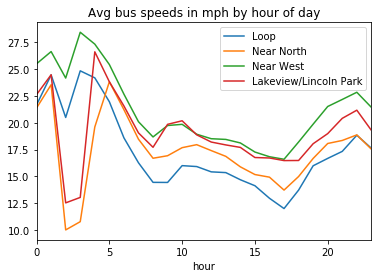

In [96]:
df_cong[(df_cong.REGION_ID == 13) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Loop') #Loop
df_cong[(df_cong.REGION_ID == 12) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near North') #Near North
df_cong[(df_cong.REGION_ID == 11) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong[(df_cong.REGION_ID == 8) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview
plt.title('Avg bus speeds in mph by hour of day')
plt.legend()
plt.savefig('Figs/bus_speed.png')
plt.show()

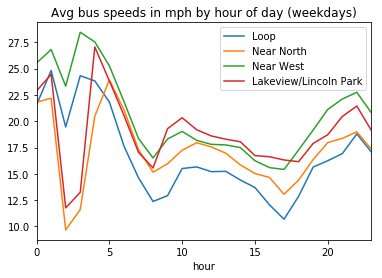

In [97]:
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 13) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Loop') #Loop
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 12) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near North') #Near North
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 11) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 8) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview
plt.title('Avg bus speeds in mph by hour of day (weekdays)')
plt.legend()
plt.savefig('Figs/weekday_bus_speed.png')
plt.show()

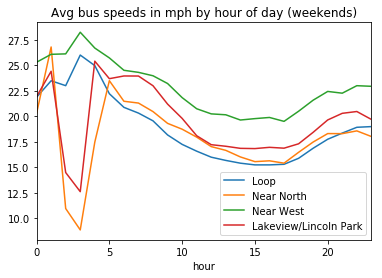

In [98]:
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 13) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Loop') #Loop
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 12) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near North') #Near North
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 11) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 8) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview
plt.title('Avg bus speeds in mph by hour of day (weekends)')
plt.legend()
plt.savefig('Figs/weekend_bus_speed.png')
plt.show()

The dips in early morning appear because very few buses are being tracked; some rows show 0.0 as the average speed. These are artifacts of the data taking process and is not indicative of the traffic condition.

Some features in the weekday plot are obvious if you spend any time in the city:
1. There is a small dip at 8-9am for the morning commute.
2. There is a deeper dip around 5pm.

The Loop is identified as uniquely congested (no surprise), with Near North firmly in second place.

Comparing also with plots for 2 other, less central areas (shown below) shows that Near West and Lakeview/Lincoln Park are not especially congested in relation to them, which is mildly surprising. The notable features for them are the slightly busier afternoon commutes for Near West, and larger nighttime and weekend activities in Lakeview/Lincoln Park.

These are statements about average speeds, and it is an open question whether areas outside the top 2 experience episodic bad traffic that may require a deeper look. Event traffic (e.g. Cubs home games in Lakeview) can be significant for short periods of time.

Nevertheless, the first focus should be the Loop, and late afternoon/early evening around 4-7pm.

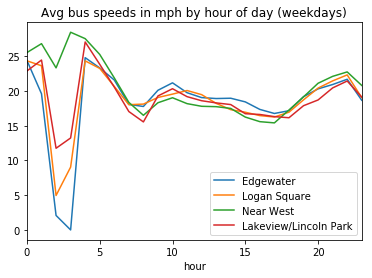

In [101]:
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 4) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Edgewater') #Edgewater
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 7) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Logan Square') #Logan Square
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 11) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong[(df_cong['weekday'] == True) & (df_cong.REGION_ID == 8) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview
plt.title('Avg bus speeds in mph by hour of day (weekdays)')
plt.legend()
plt.savefig('Figs/weekday_comparison.png')
plt.show()

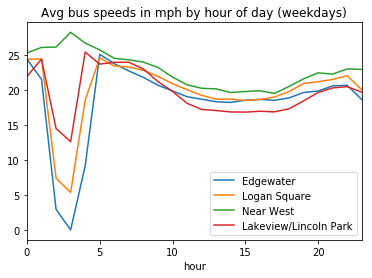

In [102]:
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 4) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Edgewater') #Edgewater
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 7) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Logan Square') #Logan Square
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 11) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Near West') #Near West
df_cong[(df_cong['weekday'] == False) & (df_cong.REGION_ID == 8) & (df_cong.year == 2015)].groupby('hour').mean()['SPEED'].plot(label='Lakeview/Lincoln Park') #Lakeview
plt.title('Avg bus speeds in mph by hour of day (weekdays)')
plt.legend()
plt.savefig('Figs/weekend_comparison.png')
plt.show()

## Where do taxis take people from/to the Loop
Now I look at a small piece of the ~40GB database of taxi trips.

In [62]:
with open('token.txt', 'r') as f:
    token = f.read().strip().split('\n')

In [63]:
#Use Chicago Data Portal API
client = Socrata("data.cityofchicago.org",
                 '3OSw2t66IrAu3NKjLzgZuRBs2',
                 username=token[0],
                 password=token[1])

In [64]:
#Get 100k rows, 2000 at a time, and process each time to get a list of dfs

#List columns I want
columns = ['fare', 'pickup_community_area', 'dropoff_community_area', 'taxi_id', 'trip_id', 'trip_start_timestamp']
dfs = list()

for i in range(50):
    results = client.get("wrvz-psew", limit=2000)
    #Convert to DataFrame
    results_df = pd.DataFrame.from_records(results)
    
    #Keep only the columns I need
    results_df = results_df[columns]
    
    #Throw away rows with missing pickup/dropoff data
    results_df = results_df[((pd.notnull(results_df.pickup_community_area)) & 
                             (pd.notnull(results_df.dropoff_community_area)))]
    #Then select trips to and from the Loop
    results_df = results_df[((results_df['pickup_community_area'] == '32') | 
                       (results_df['dropoff_community_area'] == '32'))]
    dfs.append(results_df)

In [66]:
#Concatenate, with reindexing
df_Loop = pd.concat(dfs, ignore_index=True)

In [67]:
#Make the areas int rather than str
df_Loop['pickup_community_area'] = df_Loop['pickup_community_area'].astype(int)
df_Loop['dropoff_community_area'] = df_Loop['dropoff_community_area'].astype(int)

In [68]:
#Add an hour column
df_Loop['hour'] = df_Loop.trip_start_timestamp.apply(lambda x: int(x[11:13]))

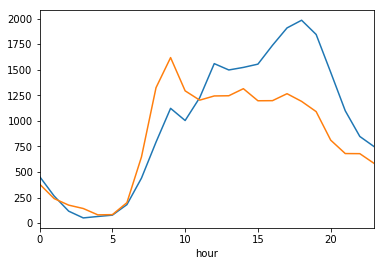

In [69]:
df_Loop[df_Loop.pickup_community_area == 32].groupby(df_Loop.hour).count()['trip_id'].plot()
df_Loop[df_Loop.dropoff_community_area == 32].groupby(df_Loop.hour).count()['trip_id'].plot()
plt.show()

In [70]:
#Keep only hour from 16 to 18 (this goes until 18:59).
df_eve_rush = df_Loop[(df_Loop.hour >= 16) & (df_Loop.hour <= 18)]

In [71]:
#How many are pickups?
print(len(df_eve_rush[df_eve_rush.pickup_community_area == 32]))
#Where do they go?
df_eve_rush[df_eve_rush.pickup_community_area == 32].groupby('dropoff_community_area').count()['trip_id']

5629


dropoff_community_area
1        5
2        5
3       26
4       12
5       21
6      200
7      246
8     2028
14       1
16       7
21       5
22      38
23       2
24     174
27       1
28     951
29       4
31      17
32    1261
33     239
34      18
35      13
38       4
39       8
40       1
41      24
42       3
43       2
44       2
48       1
56      82
57       1
59       1
60       9
61       2
62       1
70       1
76     196
77      17
Name: trip_id, dtype: int64

In [72]:
#How many are dropoffs?
print(len(df_eve_rush[df_eve_rush.dropoff_community_area == 32]))
#Where do they go?
df_eve_rush[df_eve_rush.dropoff_community_area == 32].groupby('pickup_community_area').count()['trip_id']

3652


pickup_community_area
2        3
3       10
4        1
6       51
7       46
8     1343
10       1
15       1
16       1
21       2
22       9
24      20
28     347
31       1
32    1261
33     246
34       2
35       4
38       1
39       2
40       1
41      29
42       1
56      52
76     211
77       6
Name: trip_id, dtype: int64

Make maps using Geopandas

In [73]:
import geopandas

In [74]:
chi_map = geopandas.read_file('Data/Boundaries - Community Areas (current).geojson')
#Make area_num_1 int and thne the index, as that's all I use to id them
chi_map['area_num_1'] = chi_map['area_num_1'].astype(int)
chi_map = chi_map.set_index(chi_map.area_num_1)

In [75]:
#Make column for how many trips there are to/from the Loop
df_to_Loop = df_eve_rush[df_eve_rush.dropoff_community_area == 32].groupby('pickup_community_area').count()['trip_id']
df_from_Loop = df_eve_rush[df_eve_rush.pickup_community_area == 32].groupby('dropoff_community_area').count()['trip_id']


In [76]:
chi_map['To_Loop'] = df_to_Loop
chi_map['From_Loop'] = df_from_Loop

chi_map[['To_Loop', 'From_Loop']] = chi_map[['To_Loop', 'From_Loop']].fillna(0)

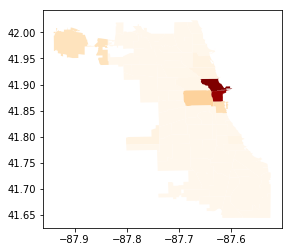

In [77]:
chi_map.plot(column='To_Loop', cmap='OrRd')
plt.show()

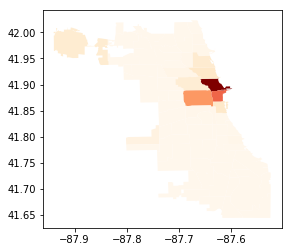

In [78]:
chi_map.plot(column='From_Loop', cmap='OrRd')
plt.show()

I should figure out how to zoom in.

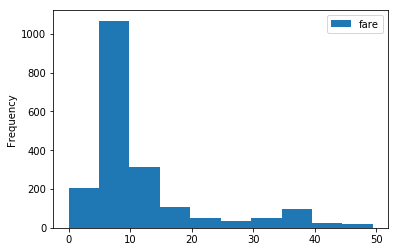

In [205]:
plt.show()

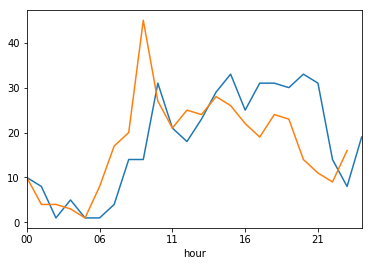

In [214]:
df1[df1.pickup_community_area == '32'].groupby(df1.hour).count()['trip_id'].plot()
df1[df1.dropoff_community_area == '32'].groupby(df1.hour).count()['trip_id'].plot()
plt.show()

Somewhat obviously, there's a peak of dropoffs in the Loop in the morning (9-10am), and there's more pickups than dropoffs in the afternoon-evening (3-10pm).

Make maps using Geopandas

In [ ]:
import geopandas

In [ ]:
chi_map = geopandas.read_file('Data/Boundaries - Community Areas (current).geojson')
#Make area_num_1 int and thne the index, as that's all I use to id them
chi_map['area_num_1'] = chi_map['area_num_1'].astype(int)
chi_map = chi_map.set_index(chi_map.area_num_1)

In [ ]:
#Make column for how many trips there are to/from the Loop
df_to_Loop = df_eve_rush[df_eve_rush.dropoff_community_area == 32].groupby('pickup_community_area').count()['trip_id']
df_from_Loop = df_eve_rush[df_eve_rush.pickup_community_area == 32].groupby('dropoff_community_area').count()['trip_id']


In [ ]:
chi_map['To_Loop'] = df_to_Loop
chi_map['From_Loop'] = df_from_Loop

chi_map[['To_Loop', 'From_Loop']] = chi_map[['To_Loop', 'From_Loop']].fillna(0)

In [ ]:
chi_map.plot(column='To_Loop', cmap='OrRd')
plt.show()

In [ ]:
chi_map.plot(column='From_Loop', cmap='OrRd')
plt.show()

I should zoom in.